## MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

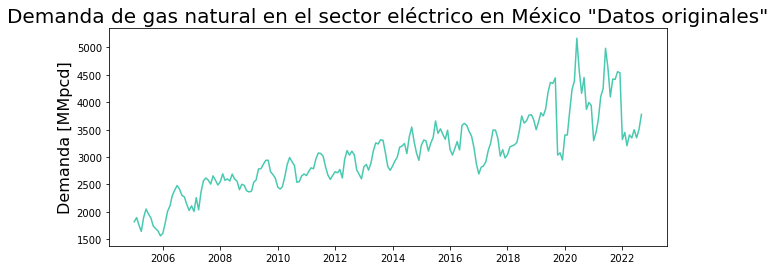

In [3]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

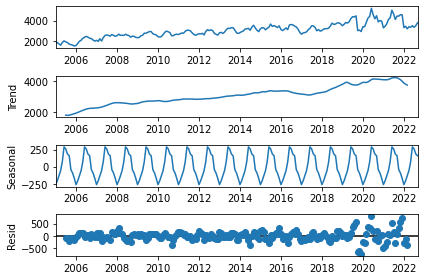

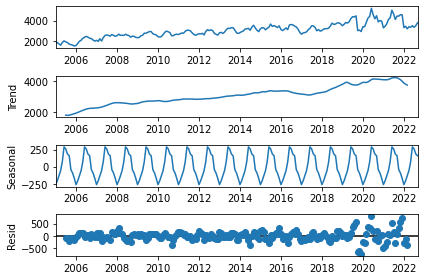

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se aplica el TimeseriesGnerator para producir sets de n_inputs + 1 output para el caso de

In [8]:
n_input = 36

# Assuming you have a column in your DataFrame named 'demand_data' that contains your time series data
data = csv_demanda_electrico_original_train_data['Demanded_Gas'].values
targets = data  # You can adjust this if your target data is different

demanda_electrico_NOscaled_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [9]:
demanda_electrico_NOscaled_train_generator[1]

(array([[1895.33, 1765.86, 1642.7 , 1895.54, 2051.72, 1962.05, 1889.66,
         1739.1 , 1695.92, 1648.95, 1560.98, 1610.45, 1806.33, 2006.88,
         2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49, 2273.91,
         2134.41, 2025.98, 2108.85, 2006.81, 2259.02, 2036.62, 2361.78,
         2567.22, 2618.43, 2579.35, 2506.83, 2657.24, 2577.97, 2489.39,
         2548.33]]),
 array([2694.39]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [10]:
print("Total number of samples in the original training data = ", len(csv_demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_NOscaled_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  165


Se importan las librerias necesarias para definir la red Neuronal de tipo Feed Forward Sequential Neural Network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU. 

La primer cada Dense constará de N, nodos y n_input inputs.
Por lo que el número de parámetros a estimar para esta primer capa sería 
Parámetros_n_capa_densa = n_input *  #Nodos + # Nodos
Donde  n_input *  #Nodos: Representa la matriz de pesos 
Y # Nodos: el vector de bias  


In [12]:
n_input = 36
n_features = 1

# define model
model_sequential_and_FF = Sequential()
model_sequential_and_FF.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_sequential_and_FF.add(Dense(32, activation='relu'))
model_sequential_and_FF.add(Dense(1))
model_sequential_and_FF.compile(optimizer='Adam', loss='mse')

In [13]:
model_sequential_and_FF.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 36, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 36, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [14]:
model_sequential_and_FF.fit(demanda_electrico_NOscaled_train_generator, epochs=25)

Epoch 1/25
165/165 [==============================] - 3s 2ms/step - loss: 876652.6250
Epoch 2/25
165/165 [==============================] - 0s 2ms/step - loss: 201776.4062
Epoch 3/25
165/165 [==============================] - 0s 2ms/step - loss: 198365.3750
Epoch 4/25
165/165 [==============================] - 0s 2ms/step - loss: 200464.3438
Epoch 5/25
165/165 [==============================] - 0s 2ms/step - loss: 202603.4688
Epoch 6/25
165/165 [==============================] - 0s 2ms/step - loss: 201776.0312
Epoch 7/25
165/165 [==============================] - 0s 2ms/step - loss: 201484.5781
Epoch 8/25
165/165 [==============================] - 0s 2ms/step - loss: 201184.5625
Epoch 9/25
165/165 [==============================] - 0s 2ms/step - loss: 214698.5000
Epoch 10/25
165/165 [==============================] - 0s 2ms/step - loss: 207241.0000
Epoch 11/25
165/165 [==============================] - 0s 2ms/step - loss: 201945.5781
Epoch 12/25
165/165 [==============================]

Se grafica la perdida por epoch 

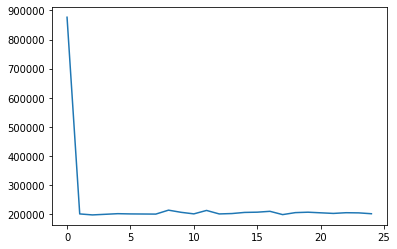

In [15]:
loss_per_epoch = model_sequential_and_FF.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [16]:

demanda_electrico_NOscaled_train_batch = csv_demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]


demanda_electrico_NOscaled_train_batch

array([3765.69, 3772.25, 3676.41, 3500.08, 3647.6 , 3807.71, 3750.5 ,
       3876.48, 4184.76, 4361.97, 4343.61, 4445.27, 3037.44, 3076.62,
       2947.09, 3402.47, 3402.47, 3819.3 , 4235.25, 4387.91, 5168.27,
       4581.99, 4163.77, 4451.61, 3869.77, 3996.14, 3941.12, 3298.43,
       3454.21, 3681.3 , 4104.82, 4243.93, 4985.53, 4631.85, 4098.81,
       4424.39])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [17]:
demanda_electrico_NOscaled_train_batch_reshaped = demanda_electrico_NOscaled_train_batch.reshape(1,n_input, n_features)
demanda_electrico_NOscaled_train_batch_reshaped

array([[[3765.69],
        [3772.25],
        [3676.41],
        [3500.08],
        [3647.6 ],
        [3807.71],
        [3750.5 ],
        [3876.48],
        [4184.76],
        [4361.97],
        [4343.61],
        [4445.27],
        [3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39]]])

In [20]:
len(demanda_electrico_NOscaled_train_batch_reshaped)

1

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [26]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)

1/1 [==============================] - 0s 20ms/step


array([[[3898.1086],
        [3904.8948],
        [3805.7488],
        [3623.3372],
        [3775.9456],
        [3941.5781],
        [3882.3948],
        [4012.7207],
        [4331.6333],
        [4514.956 ],
        [4495.9634],
        [4601.1294],
        [3144.739 ],
        [3185.2703],
        [3051.2725],
        [3522.3604],
        [3522.3604],
        [3953.5684],
        [4383.865 ],
        [4541.7915],
        [5349.0684],
        [4742.5664],
        [4309.92  ],
        [4607.688 ],
        [4005.7788],
        [4136.5073],
        [4079.59  ],
        [3414.7312],
        [3575.8843],
        [3810.8076],
        [4248.9365],
        [4392.8447],
        [5160.025 ],
        [4794.145 ],
        [4242.719 ],
        [4579.53  ]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [25]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][1][0]

1/1 [==============================] - 0s 32ms/step


3904.8948

In [27]:
test_predictions_model_sequential_and_FF = []

for i in range(12):
    prediction = model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][i][0]
    test_predictions_model_sequential_and_FF.append(prediction)

# Now, test_predictions_model_sequential_and_FF contains your 12 elements

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


In [28]:
test_predictions_model_sequential_and_FF 

[3898.1086,
 3904.8948,
 3805.7488,
 3623.3372,
 3775.9456,
 3941.5781,
 3882.3948,
 4012.7207,
 4331.6333,
 4514.956,
 4495.9634,
 4601.1294]

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos (ESCALADOS) de test de la demanda de gasd natural en sector eléctrico  

In [20]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values[0]

4417.51

In [23]:
test_predictions_model_sequential_and_FF

[4887.0796,
 5397.865,
 5961.7466,
 6584.2437,
 7271.4487,
 8030.088,
 8867.587,
 9792.1455,
 10812.811,
 11939.573,
 13183.462,
 14556.653]

In [29]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_sequential_and_FF_array = np.array(test_predictions_model_sequential_and_FF)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_sequential_and_FF_2d = test_predictions_model_sequential_and_FF_array.reshape(-1, 1)

test_predictions_model_sequential_and_FF_2d

array([[3898.1086],
       [3904.8948],
       [3805.7488],
       [3623.3372],
       [3775.9456],
       [3941.5781],
       [3882.3948],
       [4012.7207],
       [4331.6333],
       [4514.956 ],
       [4495.9634],
       [4601.1294]], dtype=float32)

In [30]:
test_predictions_model_sequential_and_FF_2d

array([[3898.1086],
       [3904.8948],
       [3805.7488],
       [3623.3372],
       [3775.9456],
       [3941.5781],
       [3882.3948],
       [4012.7207],
       [4331.6333],
       [4514.956 ],
       [4495.9634],
       [4601.1294]], dtype=float32)

In [27]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

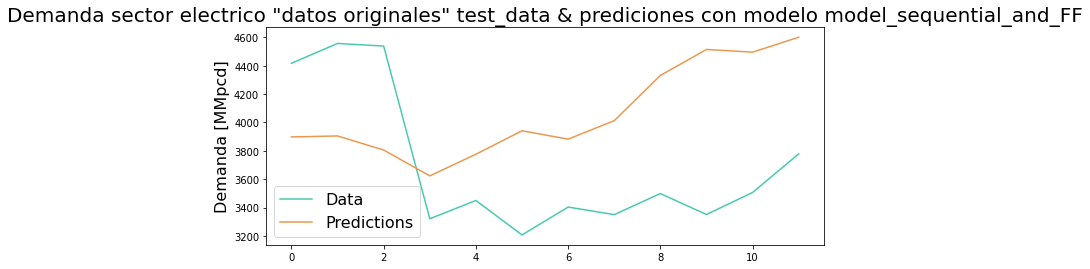

In [31]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_sequential_and_FF , color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [32]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_sequential_and_FF = mean_absolute_percentage_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF )
RMSE_predictions_model_sequential_and_FF = np.sqrt(mean_squared_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF ))

print('MAPE:', MAPE_predictions_model_sequential_and_FF)
print('RMSE:', RMSE_predictions_model_sequential_and_FF)

MAPE: 0.18841121057691188
RMSE: 727.0892640566011
